# Project 3 - Tariffline Notebook


University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering

datasci-205-2025-schioberg - Team Bella_Justin_Peter_Priscilla


In [1]:
%matplotlib inline

!pip install yfiles_jupyter_graphs --quiet
!jupyter nbextension enable --py --sys-prefix widgetsnbextension # > /dev/null 2>&1
!jupyter nbextension enable --py --sys-prefix yfiles_jupyter_graphs # > /dev/null 2>&1


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension yfiles-jupyter-graphs/extension...
      - Validating: OK


In [2]:
import csv
import math
import numpy as np
import pandas as pd
import psycopg2
import neo4j
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
import matplotlib.pyplot as plt
from IPython.display import Image

pd.set_option('display.max_colwidth', 10000)  # set width in characters

## 1.1 Data Source

### ComptradePlus UN.ORG Tariffline Dataset

We used the tariffline data from the comtradeplus dataset from un.org. Berkeley students have free access to the premium account.  We downloaded the annual 2024 datasets for 5 commodities.  Steel, Iron, US Coal, Liquefied Natural Gas Products, and Amedrican Crude Oil.  Below is the filter used to download the csv file.
https://comtradeplus.un.org/

### Countries Codes Coordinates Dataset

We used countries codes coordinates by Tadas Tamošauskas (https://gist.github.com/tadast)

countries_codes_and_coordinates.csv
https://gist.github.com/tadast/8827699

### Trump Tariffs Dataset

We used trump tariffs dataset by Michael Oliver (https://gist.github.com/mcoliver)

Whitehouse Trump Tariffs 2025-04-02
https://gist.github.com/mcoliver/69fe48d03c12388e29cc0cd87eb44df6

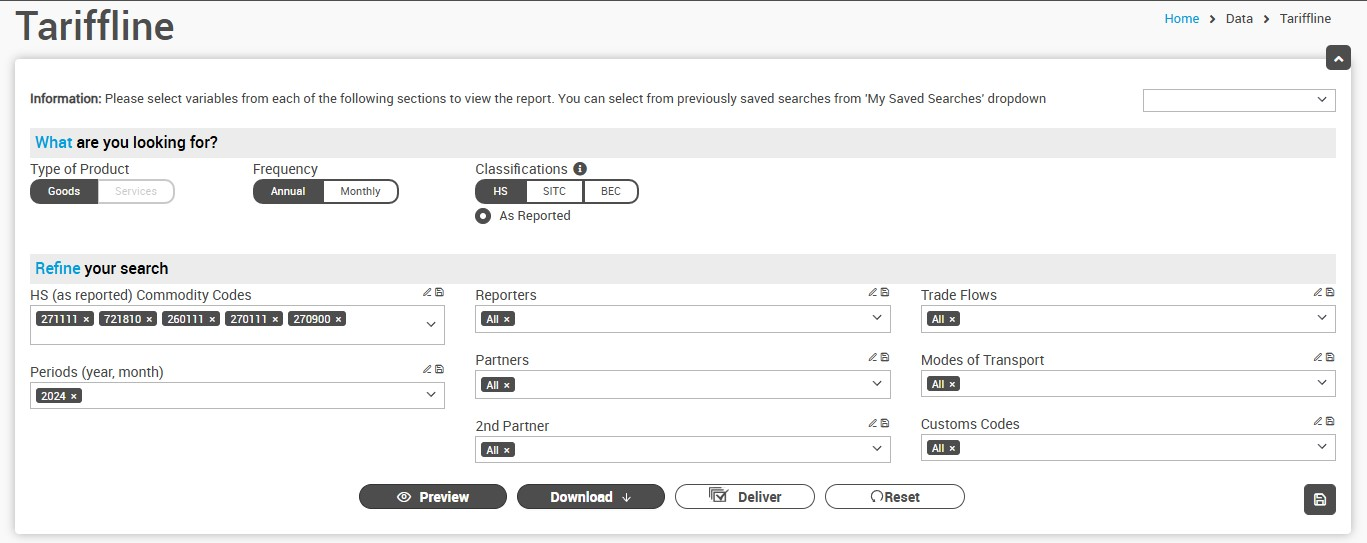

In [3]:
Image(filename='../images/tariffline_iron_steel_goal_natgas_ameroil.jpg')

In [4]:

def my_select_query_pandas(connection, query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

def my_read_csv_file(file_name, limit):
    "read the csv file and print only the first limit rows"
    
    csv_file = open(file_name, "r", encoding="unicode_escape")
    
    csv_data = csv.reader(csv_file)
    
    i = 0
    
    for row in csv_data:
        i += 1
        if i <= limit:
            print(row)
            
    print("\nPrinted ", min(limit, i), "lines of ", i, "total lines.")
    
def my_neo4j_wipe_out_database(session):
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)    
    
def my_neo4j_run_query_pandas(session, query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

def my_neo4j_number_nodes_relationships(session):
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(session, query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(session, query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

    
def my_neo4j_create_relationship_one_way(session, from_station, to_station, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)
    
def my_neo4j_create_relationship_two_way(session, from_station, to_station, weight):
    "create relationships two way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to),
           (to)-[:LINK {weight: $weight}]->(from)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)

def create_nodes():
    ''' create node for countries involve in import export and reexport '''        
    connection.rollback()

    query = """

    select distinct
        a.name
        ,a.iso
        ,a.latitude
        ,a.longitude
    from vw_countries_codes_coordinates a
    where a.iso in (
        select reporteriso from vw_tariffline where flowcode in ('M', 'X', 'RX') and trumptariffs > 0 and commodity = 'Steel'
        union select partneriso from vw_tariffline where flowcode in ('M', 'X', 'RX') and trumptariffs > 0 and commodity = 'Steel'
        union select 'USA'
    )

    """

    cursor.execute(query)

    rows = cursor.fetchall()
    for row in rows:    
        name  = row[0]
        iso  = row[1]
        latitude  = str(row[2])
        longitude = str(row[3])

        query = """

        CREATE (:Country {name: $name, iso: $iso, coordinates: [$latitude, $longitude]})

        """       
        session.run(query, name=name, iso=iso, latitude=latitude, longitude=longitude)
                
def create_edges(commodity_in = 'Steel'):
    ''' create edges for import export and reexport '''
    connection.rollback()

    query = """

    select 
        reporteriso 
        ,partneriso
        ,trumptariffs
        ,flowcode
        ,commodity
        ,primaryValue
    from vw_tariffline
    where flowcode in ('M', 'X', 'RX')
    and trumptariffs > 0

    """

    cursor.execute(query)

    rows = cursor.fetchall()
    for row in rows:    
        reporteriso  = row[0]
        partneriso   = row[1]
        trumptariffs  = float(row[2])
        flowCode     = row[3]
        commodity    = row[4]
        primaryValue = float(row[5])
        
        if commodity != commodity_in:
            continue

        source = reporteriso
        target = partneriso

        if flowCode == 'M':
            source, target = target, source
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:IMPORT {
                                        name: round(($trumptariffs - 1) * 100) + '%', 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                   }]->(to)

            """
        elif flowCode == 'X':
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:EXPORT {
                                        name: round(($trumptariffs - 1) * 100) + '%', 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                    }]->(to)

            """
        else:
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:RE_EXPORT {
                                        name: round(($trumptariffs - 1) * 100) + '%', 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                        }]->(to)

            """
        session.run(query, source=source, target=target, commodity=commodity, trumptariffs=trumptariffs)      

def showGraph(cypher: str):
    widget = GraphWidget(graph = session.run(cypher).graph())    
    return widget

def deleteEdge(country_a: str, country_b: str):
    query = f'MATCH (node1 {{name: \'{country_a}\'}})-[r]-(node2 {{name: \'{country_b}\'}}) '
    query += 'DELETE r'
    session.run(query)


## 1.2 Connection for the notebook

Connection is use throughout the notebook

In [5]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)
cursor = connection.cursor()

## 1.3 Drop and recreate all database tables and views

* tariffline
* trump_tarriffs
* countries_codes_coordinates

* vw_tariffline
* vw_trump_tariffs
* vw_countries_codes_coordinates


In [6]:
connection.rollback()

cursor.execute("drop view if exists vw_tariffline;")
cursor.execute("drop view if exists vw_trump_tariffs;")
cursor.execute("drop view if exists vw_countries_codes_coordinates;")
cursor.execute("drop table if exists tariffline;")
cursor.execute("drop table if exists trump_tariffs;")
cursor.execute("drop table if exists countries_codes_coordinates;")
cursor.execute("drop table if exists eu_alphaisocodes;")

query = """
create table eu_alphaisocodes (
    country varchar(200),
    alphaisocode varchar(32)
);
"""
cursor.execute(query)

query = """
create table countries_codes_coordinates (
    country varchar(200),
    "alpha-2 code" varchar(32),
    "alpha-3 code" varchar(32),
    "Numeric code" varchar(32),
    "Latitude (average)" numeric(32,2),
    "Longitude (average)" numeric(32,2)
);
"""
cursor.execute(query)

query = """
create table tariffline (
    typeCode varchar(32),
    freqCode varchar(32),
    refPeriodId varchar(32),
    period varchar(32),
    reporterCode varchar(32),
    reporterDesc varchar(200),
    reporterISO varchar(32),
    flowCode varchar(32),
    flowDesc varchar(200),
    partnerCode varchar(32),
    partnerDesc varchar(200),
    partnerISO varchar(32),
    partner2Code varchar(32),
    partner2Desc varchar(200),
    partner2ISO varchar(32),
    classificationCode varchar(32),
    cmdCode varchar(32),
    cmdDesc varchar(200),
    customsCode varchar(32),
    customsDesc varchar(200),
    mosCode varchar(32),
    motCode varchar(32),
    motDesc varchar(200),
    qtyUnitCode varchar(32),
    qtyUnitAbbr varchar(32),
    qty numeric(32, 2),
    altQtyUnitCode varchar(32),
    altQtyUnitAbbr varchar(32),
    altQty varchar(32),
    netWgt varchar(32),
    grossWgt numeric(32, 2),
    cifvalue numeric(32, 2),
    fobvalue numeric(32, 2),
    primaryValue numeric(32, 2),
    tariffRate  numeric(32, 2)
);
"""
cursor.execute(query)

query = """
create table trump_tariffs (
    country varchar(200),
    "Tariffs Charged to the U.S.A." varchar(32),
    "U.S.A. Discounted Reciprocal Tariffs" varchar(32)
);
"""
cursor.execute(query)

query = """

create view vw_trump_tariffs as 
with eu_tariffs as (
	select b.country
		,b.alphaisocode iso	
	    ,0.01*replace(a."U.S.A. Discounted Reciprocal Tariffs", '%', '')::numeric tariffs_reciprocol_usa
	    ,0.01*replace(a."Tariffs Charged to the U.S.A.", '%', '')::numeric tariffs_charged_usa
	from trump_tariffs a
	cross join eu_alphaisocodes b
	where a.country = 'European Union'
)
select * from eu_tariffs
union
select 
    a.country
    ,ltrim(b."alpha-3 code") iso
    ,0.01*replace(a."U.S.A. Discounted Reciprocal Tariffs", '%', '')::numeric tariffs_reciprocol_usa
    ,0.01*replace(a."Tariffs Charged to the U.S.A.", '%', '')::numeric tariffs_charged_usa
from trump_tariffs a
left join countries_codes_coordinates b on a.country = b.country
union select 'United States', 'USA', 0, 0
union select 'Canada', 'CAN', .2, .2



"""
cursor.execute(query)

query = """
create view vw_countries_codes_coordinates
as 
select country name, ltrim("alpha-3 code") iso, "Latitude (average)" latitude, "Longitude (average)" longitude
from countries_codes_coordinates
"""
cursor.execute(query)

query = """

create view vw_tariffline as
with dataset as (
	select 
		reporteriso
		,partneriso
		,flowcode
		,case 	when cmdCode like '271111%' then 'Liquefied Natural Gas'
				when cmdCode like '721810%' then 'Steel'
				when cmdCode like '260111%' then 'Iron'
				when cmdCode like '270111%' then 'US Coal'
				when cmdCode like '27090010%' then 'American Crude Oil'
		 else null end commodity
		,cifvalue
		,fobvalue
		,primaryValue
		,case  when flowcode = 'M' and a.reporteriso = 'USA' and c.tariffs_reciprocol_usa is not null then 1 + c.tariffs_reciprocol_usa
		       when flowcode in ('X', 'RX') and a.partneriso  = 'USA' and b.tariffs_reciprocol_usa is not null then 1 + b.tariffs_reciprocol_usa
			   else 1.0 end trumpTariffs
	from tariffline a
	join vw_trump_tariffs b on a.reporteriso = b.iso
	join vw_trump_tariffs c on a.partneriso = c.iso
) select
		reporteriso
		,partneriso
		,flowcode
		,commodity
		,sum(cifValue) cifValue
		,sum(fobValue) fobValue
		,sum(primaryValue) primaryValue
		,max(trumpTariffs) trumpTariffs
from dataset
group by reporteriso
		,partneriso
		,flowcode
		,commodity;


"""
cursor.execute(query)

connection.commit()


## 1.3 Examine the csv tariffline.csv 

Display the first 5 rows in the CSV file.

```
['typeCode', 'freqCode', 'refPeriodId', 'period', 'reporterCode', 'reporterDesc', 'reporterISO', 'flowCode', 'flowDesc', 'partnerCode', 'partnerDesc', 'partnerISO', 'partner2Code', 'partner2Desc', 'partner2ISO', 'classificationCode', 'cmdCode', 'cmdDesc', 'customsCode', 'customsDesc', 'mosCode', 'motCode', 'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty', 'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'netWgt', 'grossWgt', 'cifvalue', 'fobvalue', 'primaryValue']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '380', 'Italy', 'ITA', '-1', 'N/A', 'N/A', 'H6', '27011100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '721291', '8', 'kg', '721291', '721291', '0', '0', '283115.3561425672', '283115.3561425672', '']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '380', 'Italy', 'ITA', '-1', 'N/A', 'N/A', 'H6', '27011100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '136212', '8', 'kg', '136212', '136212', '0', '0', '61131.116572064', '61131.116572064', '']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '380', 'Italy', 'ITA', '-1', 'N/A', 'N/A', 'H6', '27111100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '2683.8', '8', 'kg', '2683.8', '2683.8', '0', '0', '1295.60941062', '1295.60941062', '']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '442', 'Luxembourg', 'LUX', '-1', 'N/A', 'N/A', 'H6', '27011100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '32905', '8', 'kg', '32905', '32905', '0', '0', '20048.3163037178', '20048.3163037178', '']

Printed  5 lines of  10532 total lines.
```


In [7]:
my_read_csv_file("../data/Tariffline_iron_steel_goal_natgas_ameroil.csv", limit=5)

['typeCode', 'freqCode', 'refPeriodId', 'period', 'reporterCode', 'reporterDesc', 'reporterISO', 'flowCode', 'flowDesc', 'partnerCode', 'partnerDesc', 'partnerISO', 'partner2Code', 'partner2Desc', 'partner2ISO', 'classificationCode', 'cmdCode', 'cmdDesc', 'customsCode', 'customsDesc', 'mosCode', 'motCode', 'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty', 'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'netWgt', 'grossWgt', 'cifvalue', 'fobvalue', 'primaryValue']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '380', 'Italy', 'ITA', '-1', 'N/A', 'N/A', 'H6', '27011100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '721291', '8', 'kg', '721291', '721291', '0', '0', '283115.3561425672', '283115.3561425672', '']
['C', 'A', '20240101', '2024', '56', 'Belgium', 'BEL', 'X', 'Export', '380', 'Italy', 'ITA', '-1', 'N/A', 'N/A', 'H6', '27011100', '', '-1', 'N/A', '-1', '-1', 'Not available or not specified.', '8', 'kg', '136212', '8', 'kg', '13621

## 1.4 Load and transform tariffline

Load the csv.  Derive a commodity description column cmdDesc based on the HS Codes.


In [8]:
connection.rollback()

query = """

copy tariffline
from '/user/projects/project-3-bellad21992/data/Tariffline_iron_steel_goal_natgas_ameroil.csv' delimiter ',' NULL '' csv header encoding 'LATIN1';

"""

cursor.execute(query)

# backfill cmdDesc 
# 271111 Liquefied Natural Gas Products
# 721810 Steel
# 260111 Iron
# 270111 US Coal
# 270900 American Crude Oil

query = """

update tariffline
set cmdDesc = 
case
    when cmdCode like '271111%' then 'Liquefied Natural Gas'
    when cmdCode like '721810%' then 'Steel'
    when cmdCode like '260111%' then 'Iron'
    when cmdCode like '270111%' then 'US Coal'
    when cmdCode like '270900%' then 'American Crude Oil'
    else cmdDesc
end;

"""
cursor.execute(query)
connection.commit()

# 1.5 Examine the imported table

Top USA Steep Import


In [9]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select reporterdesc, partnerdesc, flowdesc, cmdDesc, sum(primaryvalue) total_primaryvalue
from tariffline
where reporteriso = 'USA'
and flowcode = 'M'
and cmdDesc = 'Steel'
group by reporterdesc, partnerdesc, flowdesc, cmdDesc
order by total_primaryvalue desc

"""

my_select_query_pandas(connection, query, rollback_before_flag, rollback_after_flag)

,reporterdesc,partnerdesc,flowdesc,cmddesc,total_primaryvalue
0,USA,Canada,Import,Steel,31260273
1,USA,Italy,Import,Steel,6951724
2,USA,Australia,Import,Steel,5039233
3,USA,Mexico,Import,Steel,2363681
4,USA,United Kingdom,Import,Steel,1434386
5,USA,China,Import,Steel,84383
6,USA,India,Import,Steel,75156
7,USA,Rep. of Korea,Import,Steel,38689
8,USA,Metropolitan France,Import,Steel,9576
9,USA,Sweden,Import,Steel,5839


## 1.6 Example USA Steel Imports along with import tariffs

In [10]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from vw_tariffline
where 
    reporteriso = 'USA'
    and flowcode = 'M'
    and commodity = 'Steel'
order by trumptariffs desc
;

"""

my_select_query_pandas(connection, query, rollback_before_flag, rollback_after_flag)


,reporteriso,partneriso,flowcode,commodity,cifvalue,fobvalue,primaryvalue,trumptariffs
0,USA,CAN,M,Steel,31260273,31227101,31260273,1.2


## 1.7 read csv of country codes coordinates supporting dataset for geomap visualizations

* country codes
* supplimentary eu alpha iso codes (from ChatGPT)


In [11]:
my_read_csv_file("../data/countries_codes_and_coordinates.csv", limit=5)

['Country', 'Alpha-2 code', 'Alpha-3 code', 'Numeric code', 'Latitude (average)', 'Longitude (average)']
['Afghanistan', ' "AF"', ' "AFG"', ' "4"', ' "33"', ' "65"']
['Ã\x85land Islands', ' "AX"', ' "ALA"', ' "248"', '  "60.116667"', ' "19.9"']
['Albania', ' "AL"', ' "ALB"', ' "8"', ' "41"', ' "20"']
['Algeria', ' "DZ"', ' "DZA"', ' "12"', ' "28"', ' "3"']

Printed  5 lines of  263 total lines.


In [12]:
connection.rollback()

query = """

copy countries_codes_coordinates
from '/user/projects/project-3-bellad21992/data/countries_codes_and_coordinates.csv' delimiter ',' NULL '' csv header encoding 'LATIN1';

"""
cursor.execute(query)

query = """

copy eu_alphaisocodes
from '/user/projects/project-3-bellad21992/data/eu_alphaiso_codes.csv' delimiter ',' NULL '' csv header encoding 'LATIN1';

"""
cursor.execute(query)

connection.commit()


## 1.8 Examine countries code coordinates view

In [13]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from vw_countries_codes_coordinates
where iso like '%US%'
;

"""

my_select_query_pandas(connection, query, rollback_before_flag, rollback_after_flag)

,name,iso,latitude,longitude
0,Australia,AUS,-27.00,133.00
1,Mauritius,MUS,-20.28,57.55
2,Russia,RUS,60.00,100.00
3,Russian Federation,RUS,60.00,100.00
4,United States,USA,38.00,-97.00


## 1.9 Read Trump Tariffs csv

https://gist.github.com/mcoliver/69fe48d03c12388e29cc0cd87eb44df6

In [14]:
my_read_csv_file("../data/Trump_Tariffs_202050402.csv", limit=5)

['Country', 'Tariffs Charged to the U.S.A.', 'U.S.A. Discounted Reciprocal Tariffs']
['Afghanistan', '49%', '10%']
['Antigua and Barbuda', '10%', '10%']
['Argentina', '10%', '10%']
['Aruba', '10%', '10%']

Printed  5 lines of  127 total lines.


## 1.10 Import and view trump tariffs data

In [15]:
connection.rollback()

query = """

copy trump_tariffs
from '/user/projects/project-3-bellad21992/data/Trump_Tariffs_202050402.csv' delimiter ',' NULL '' csv header encoding 'LATIN1';

"""
cursor.execute(query)

connection.commit()

In [16]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from vw_trump_tariffs
where country in ('China', 'Vietnam', 'European Union', 'United Kingdom')
order by 3
;

"""

my_select_query_pandas(connection, query, rollback_before_flag, rollback_after_flag)

,country,iso,tariffs_reciprocol_usa,tariffs_charged_usa
0,United Kingdom,GBR,0.10,0.10
1,European Union,None,0.20,0.39
2,China,CHN,0.34,0.67
3,Vietnam,VNM,0.46,0.90


## 2.1 Graph Visualization and Analysis

This notebook will examine how the Trump tariffs will affect the global trade landscape using graph algorithms and yfiles visualizations.

In [17]:

driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))
session = driver.session(database="neo4j")


## 2.2 Methods for creating nodes and edges

### Node 
Create a node for each country with attributes:
- Coordinates: Lat / Long
- ISO: iso code
- Name: Name
Include all countires that is either a reporter or a partner from tariffline dataset

### Edge
Create directional edges for Import, Export, and Re-export based on flowcode M, X, RX.
Attributes for edge are:
- fob    value of goods in departure
- cif    value of goods upon arrival
- trade  value of goods
- trumptariff 

### Commodity Types

Parameter for: commodity_in

- 'Liquefied Natural Gas'
- 'Steel'
- 'Iron'
- 'US Coal'
- 'American Crude Oil'
 

In [18]:
def create_nodes():
    ''' create node for countries involve in import export and reexport '''        
    connection.rollback()

    query = """

    select distinct
        a.name
        ,a.iso
        ,a.latitude
        ,a.longitude
    from vw_countries_codes_coordinates a
    where a.iso in (
        select reporteriso from vw_tariffline where flowcode in ('M', 'X', 'RX') and trumptariffs > 0 and commodity = 'Steel'
        union select partneriso from vw_tariffline where flowcode in ('M', 'X', 'RX') and trumptariffs > 0 and commodity = 'Steel'
        union select 'USA'
    )

    """

    cursor.execute(query)

    rows = cursor.fetchall()
    for row in rows:    
        name  = row[0]
        iso  = row[1]
        latitude  = str(row[2])
        longitude = str(row[3])

        query = """

        CREATE (:Country {name: $name, iso: $iso, coordinates: [$latitude, $longitude]})

        """       
        session.run(query, name=name, iso=iso, latitude=latitude, longitude=longitude)
                
def create_edges(commodity_in = 'Steel'):
    ''' create edges for import export and reexport '''
    connection.rollback()

    query = """

    select 
        reporteriso 
        ,partneriso
        ,trumptariffs
        ,flowcode
        ,commodity
        ,primaryValue
    from vw_tariffline
    where flowcode in ('M', 'X', 'RX')
    and trumptariffs > 0

    """

    cursor.execute(query)

    rows = cursor.fetchall()
    for row in rows:    
        reporteriso  = row[0]
        partneriso   = row[1]
        trumptariffs  = float(row[2])
        flowCode     = row[3]
        commodity    = row[4]
        primaryValue = float(row[5])
        
        if commodity != commodity_in:
            continue

        source = reporteriso
        target = partneriso
        
        formattedvalue = f'{round((trumptariffs - 1) * 100)}%'

        if flowCode == 'M':
            source, target = target, source
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:IMPORT {
                                        name: $formattedvalue, 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                   }]->(to)

            """
        elif flowCode == 'X':
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:EXPORT {
                                        name: $formattedvalue, 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                    }]->(to)

            """
        else:
            query = """

            MATCH (from:Country), 
                  (to:Country)
            WHERE from.iso = $source and to.iso = $target
            CREATE (from)-[:RE_EXPORT {
                                        name: $formattedvalue, 
                                        trumptariffs: $trumptariffs,
                                        commodity: $commodity
                                        }]->(to)

            """
        session.run(query, source=source, target=target, commodity=commodity, trumptariffs=trumptariffs, 
                    formattedvalue = formattedvalue)      


In [19]:
def edge_style_function(edge):
    edge_properties = edge['properties']

    # Determine color based on flow type (Import/Export)
    flow_type = "IMPORT" if "IMPORT" in edge_properties.get('label', '') else "EXPORT"
    color = "#F44336" if flow_type == "IMPORT" else "#4CAF50"  # Red for Import, Green for Export

    # Calculate thickness based on weight
    # thickness = edge_properties.get('weight', 1) / 100000000000  # Scale thickness by weight

    # Return a dictionary of styles
    return {
        'curve': 'curved',
        'curvature': 0.5,
        'color': color,
        # 'thickness': max(thickness, 0.5)  # Ensure a minimum thickness
    }

def showGraph(cypher: str):
    widget = GraphWidget(graph = session.run(cypher).graph())    
    widget.set_edge_styles_mapping(edge_style_function)
    return widget

def deleteEdge(country_a: str, country_b: str):
    query = f'MATCH (node1 {{name: \'{country_a}\'}})-[r]-(node2 {{name: \'{country_b}\'}}) '
    query += 'DELETE r'
    session.run(query)


## 2.3 Build Graph




In [20]:
my_neo4j_wipe_out_database(session)
create_nodes()
create_edges('Steel')

my_neo4j_number_nodes_relationships(session)

-------------------------
  Nodes: 69
  Relationships: 474
-------------------------


In [21]:
my_neo4j_wipe_out_database(session)

create_nodes()
create_edges('Steel')
w = showGraph("Match (n)-[r]->(m) Return n,r,m limit 40")
w.hierarchic_layout()
display(w)


GraphWidget(layout=Layout(height='790px', width='100%'))

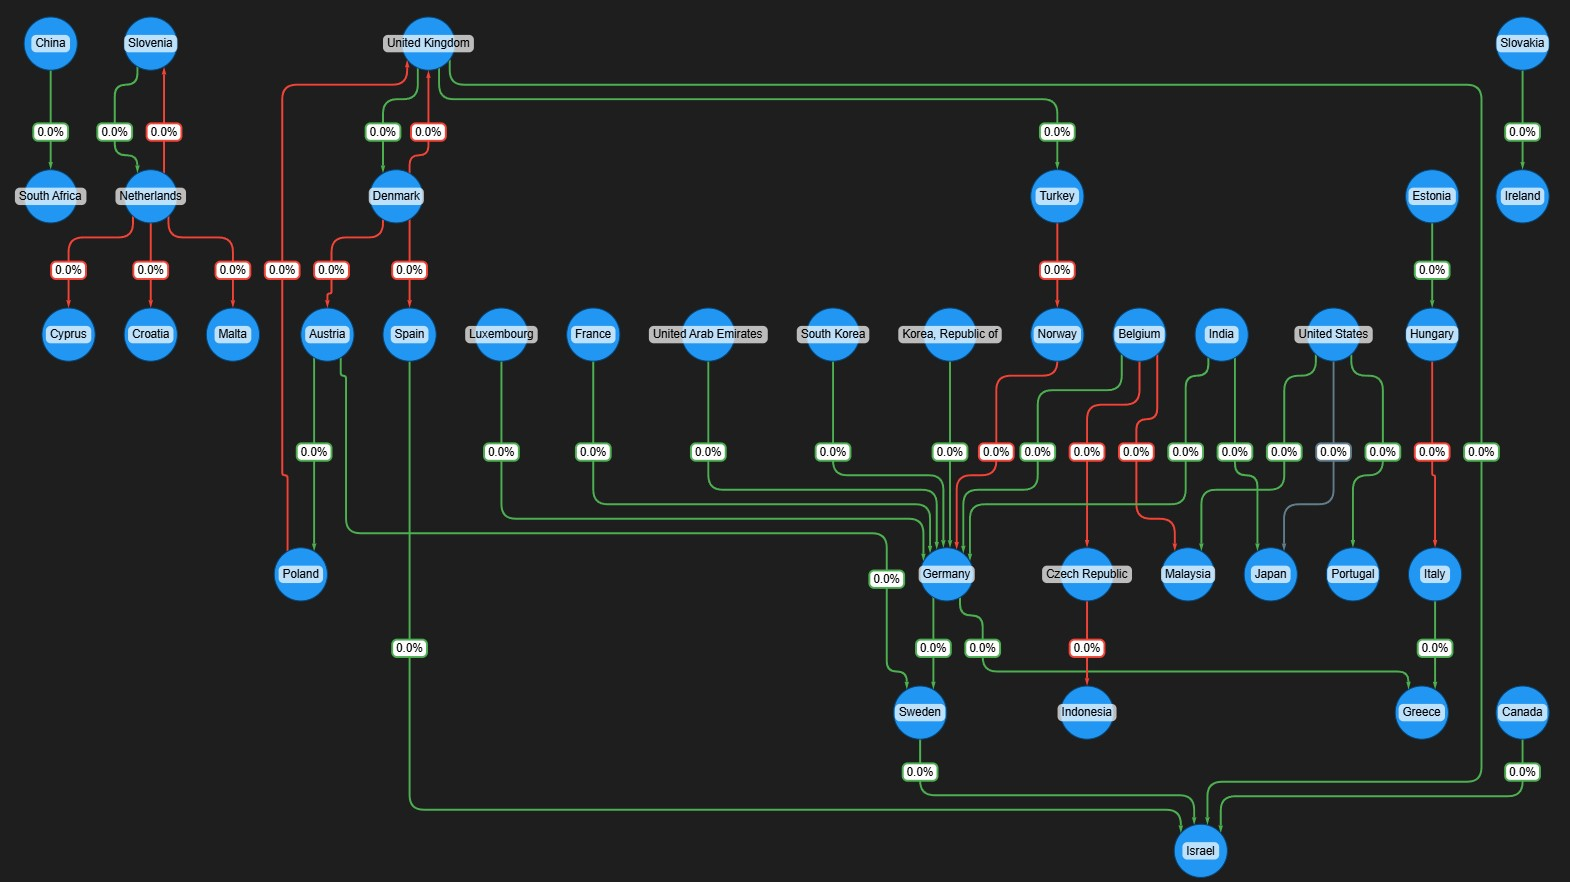

In [22]:
 Image(filename='../images/tariff_neo4j1.jpg')

## 2.4 - Round about paths where Canada Steel can make it to U.S.A. in 3 hops

Show in geospatial layout

In [23]:
def round_about_trade(commodity_in = 'Steel', reporteriso = 'Canada', partneriso = 'United States'):
    my_neo4j_wipe_out_database(session)
    create_nodes()
    create_edges(commodity_in)
    deleteEdge(reporteriso, partneriso)
    w = showGraph(f"""
    
    MATCH (startNode:Country {{name: '{reporteriso}'}})
    MATCH p = (startNode)-[*1..3]->(endNode:Country {{name: '{partneriso}'}})
    RETURN startNode, p
    
    """)
    w.node_coordinate_mapping = 'coordinates'
    w.get_node_coordinate_mapping()
    w.map_layout()    
    return w

def round_about_trade_hierview(commodity_in = 'Steel', reporteriso = 'Canada', partneriso = 'United States'):
    w = round_about_trade(commodity_in, reporteriso, partneriso)
    w.hierarchic_layout()
    return w


def round_about_trade_mapview(commodity_in = 'Steel', reporteriso = 'Canada', partneriso = 'United States'):
    w = round_about_trade(commodity_in, reporteriso, partneriso)
    w.map_layout()
    return w


In [24]:
# display(round_about_trade_mapview())

display(round_about_trade_mapview('Steel', 'Canada', 'United States'))


GraphWidget(layout=Layout(height='720px', width='100%'))

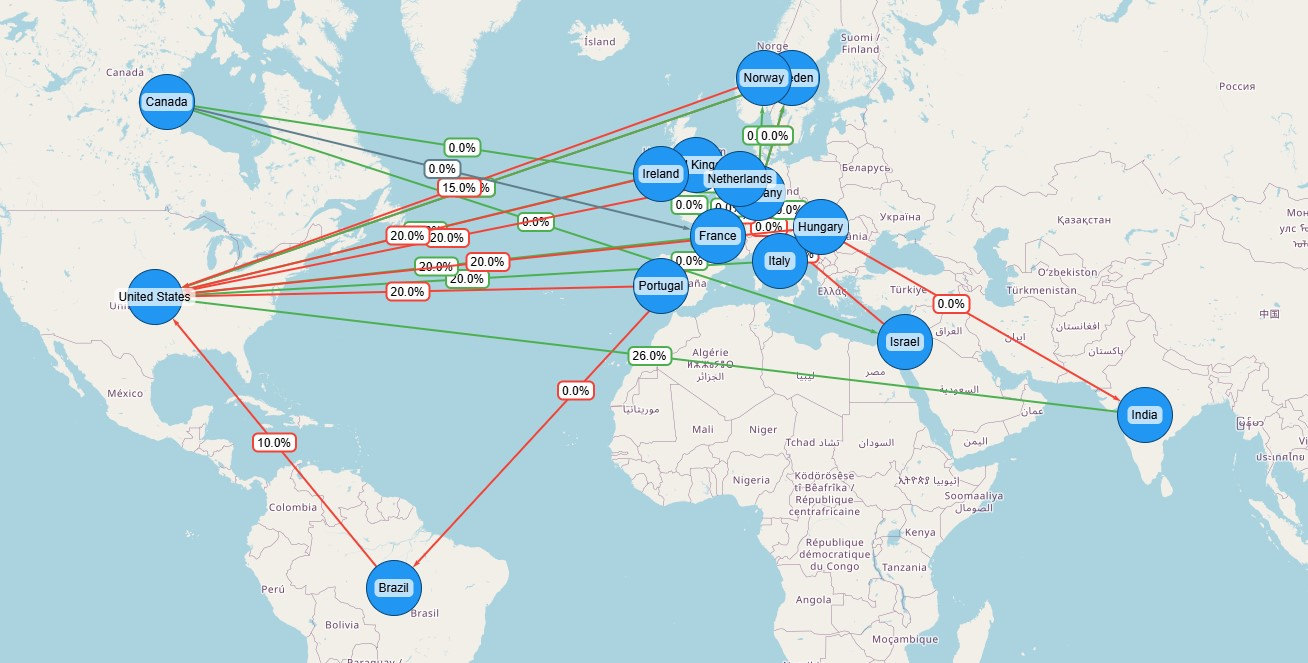

In [25]:
 Image(filename='../images/tariff_neo4j2.jpg')

## 2.5 - Round about paths where Canada Steel can make it to U.S.A. in 3 hops

Show in hierarchical layout

In [26]:
def round_about_trade(commodity_in = 'Steel', reporteriso = 'Canada', partneriso = 'United States'):
    my_neo4j_wipe_out_database(session)
    create_nodes()
    create_edges(commodity_in)
    deleteEdge(reporteriso, partneriso)
    w = showGraph(f"""
    
    MATCH (startNode:Country {{name: '{reporteriso}'}})
    MATCH p = (startNode)-[*1..3]->(endNode:Country {{name: '{partneriso}'}})
    RETURN startNode, p LIMIT 20
    
    """)
    w.node_coordinate_mapping = 'coordinates'
    w.get_node_coordinate_mapping()    
    w.radial_layout()
    return w

# display(round_about_trade('Iron'))
display(round_about_trade('Steel', 'Canada', 'United States'))

GraphWidget(layout=Layout(height='660px', width='100%'))

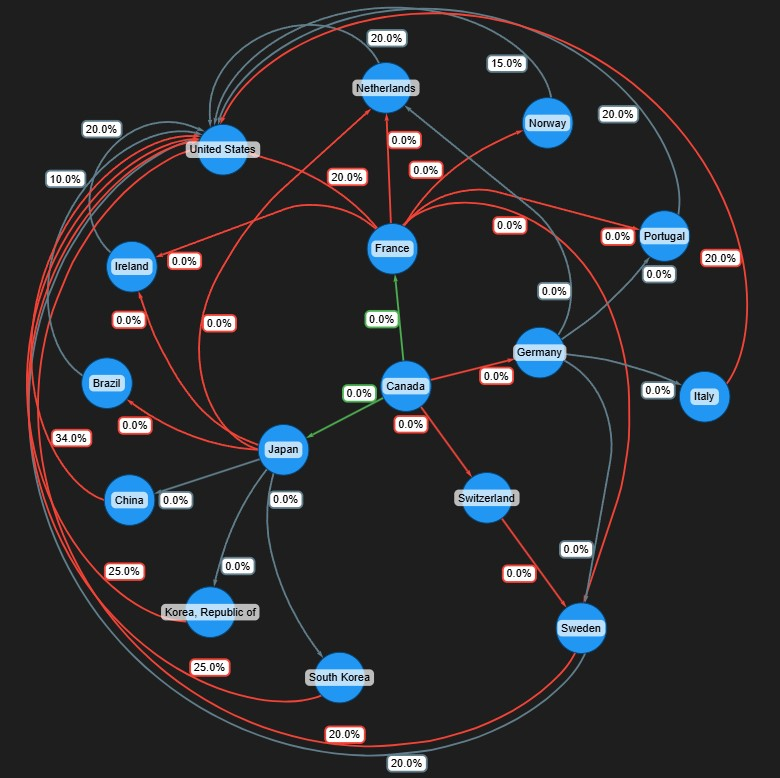

In [27]:
 Image(filename='../images/tariff_neo4j3.jpg')

## 2.6 Find 10 least tariffs path from Canada to U.S.A.

Using Yen's Algorithms

In [28]:
# yens algorithms
def yens(commodity_in = 'Steel'):
    
    create_nodes()    
    create_edges(commodity_in)
    deleteEdge('United States', 'Canada')

    query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Country', ['EXPORT', 'IMPORT', 'RE_EXPORT'], {relationshipProperties: 'trumptariffs'})"
    session.run(query)

    query = """

    MATCH (source:Country {name: 'Canada'}), (target:Country {name: 'United States'})
    CALL gds.shortestPath.yens.stream('ds_graph', {
        sourceNode: id(source),
        targetNode: id(target),
        k: 10,                                // Request the top 10 shortest paths
        relationshipWeightProperty: 'trumptariffs'   // Use 'cost' property as weight
    })
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        index,                             // Rank of the path (0 for shortest, 1 for 2nd shortest, etc.)
        totalCost,                         // Total cost (sum of weights) of the path
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodeNames, // Get node names in the path
        path                               // The path object itself
    ORDER BY index ASC


    """

    return my_neo4j_run_query_pandas(session, query)
    
my_neo4j_wipe_out_database(session)
shortest_paths_steel = yens('Steel')
shortest_paths_steel.rename(columns={'totalCost': 'Combined Tariffs'}, inplace=True)
shortest_paths_steel.rename(columns={'nodeNames': 'Path Nodes'}, inplace=True)
shortest_paths_steel.drop('path', axis=1, inplace=True)
shortest_paths_steel.drop('index', axis=1, inplace=True)
display(shortest_paths_steel)


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 6, column: 21, offset: 192} for query: "\n\n    MATCH (source:Country {name: 'Canada'}), (target:Country {name: 'United States'})\n    CALL gds.shortestPath.yens.stream('ds_graph', {\n        sourceNode: id(source),\n        targetNode: id(target),\n        k: 10,                                // Request the top 10 shortest paths\n        relationshipWeightProperty: 'trumptariffs'   // Use 'cost' property as weight\n    })\n    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path\n    RETURN\n        index,                             // Rank of the path (0 for shortest, 1 for 2nd shortest, etc.)\n        totalCost,                         // Total cost (sum of weights) o

,Combined Tariffs,Path Nodes
0,2.20,"[Canada, Sweden, United States]"
1,2.20,"[Canada, France, United States]"
2,2.20,"[Canada, Sweden, United States]"
3,3.10,"[Canada, Germany, United Kingdom, United States]"
4,3.10,"[Canada, Sweden, United Kingdom, United States]"
5,3.10,"[Canada, Germany, Brazil, United States]"
6,3.10,"[Canada, Sweden, Brazil, United States]"
7,3.10,"[Canada, Israel, United Kingdom, United States]"
8,3.10,"[Canada, Japan, Brazil, United States]"
9,3.15,"[Canada, France, Norway, United States]"


## 2.7 Major Exports Hubs By Commodities

Degree Centrality based on tariffs on exports

In [29]:

def major_exports(commodity_in = 'Steel'):
    my_neo4j_wipe_out_database(session)
    create_nodes()
    create_edges(commodity_in)

    query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Country', ['EXPORT', 'RE_EXPORT'], {relationshipProperties: 'primaryValue'})"
    session.run(query)

    query = """

    CALL gds.degree.stream('ds_graph', {relationshipTypes:['EXPORT', 'RE_EXPORT']})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS country, score as exports
    ORDER BY exports DESC, country
    LIMIT 10;

    """

    df = my_neo4j_run_query_pandas(session, query)
    df.rename(columns={'exports': commodity_in}, inplace=True)
    return df

major_exports('Steel')
# display(pd.concat([
#                     major_exports('Steel'), 
#                     # major_exports('Iron'),
#                     # major_exports('US Coal'),
#                     # major_exports('American Crude Oil'),
#                     # major_exports('Liquefied Natural Gas'),
#                   ], axis=1))


,country,Steel
0,Netherlands,38.0
1,United States,24.0
2,Sweden,19.0
3,Denmark,17.0
4,Germany,17.0
5,Belgium,15.0
6,Poland,10.0
7,Czech Republic,9.0
8,Norway,9.0
9,Japan,7.0


## 2.8 Major Import Hubs By Commodities

Degree Centrality based on tariffs on imports

In [30]:
def major_exports(commodity_in = 'Steel'):
    my_neo4j_wipe_out_database(session)
    create_nodes()
    create_edges(commodity_in)

    query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Country', ['IMPORT'], {relationshipProperties: 'primaryValue'})"
    session.run(query)

    query = """

    CALL gds.degree.stream('ds_graph', {relationshipTypes:['IMPORT']})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS country, score as exports
    ORDER BY exports DESC, country
    LIMIT 10;

    """

    df = my_neo4j_run_query_pandas(session, query)
    df.rename(columns={'exports': commodity_in}, inplace=True)
    return df


import_hubs = major_exports('Steel')
import_hubs.rename(columns={'country': 'Country'}, inplace=True)
import_hubs

# display(pd.concat([
#                     major_exports('Steel'), 
#                     major_exports('Iron'),
#                     major_exports('US Coal'),
#                     major_exports('American Crude Oil'),
#                     # major_exports('Liquefied Natural Gas'),
#                   ], axis=1))

,Country,Steel
0,China,19.0
1,United States,19.0
2,United Kingdom,16.0
3,Italy,14.0
4,France,11.0
5,Germany,11.0
6,India,11.0
7,Netherlands,11.0
8,Denmark,9.0
9,Sweden,9.0


## 2.9 World major exports trade blocks

Louvain Modularity analysis

In [31]:
def major_trade_blocks(commodity_in = 'Steel'):
    my_neo4j_wipe_out_database(session)
    create_nodes()
    create_edges(commodity_in)
    query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Country', ['EXPORT', 'RE_EXPORT'], {relationshipProperties: 'primaryValue'})"
    session.run(query)

    query = """

    CALL gds.louvain.stream('ds_graph', {includeIntermediateCommunities: true})
    YIELD nodeId, communityId, intermediateCommunityIds
    RETURN gds.util.asNode(nodeId).name AS country, communityId as community, intermediateCommunityIds as intermediate_community
    ORDER BY community, country ASC

    """

    lovuvain = my_neo4j_run_query_pandas(session, query)
    community_groups = lovuvain.groupby("community")["country"].agg(list).reset_index()
    community_groups['Countries'] = community_groups["country"].apply(len)
    #community_groups.rename(columns={'community': commodity_in}, inplace=True)

    return community_groups.sort_values(by="Countries", ascending=False)    



community_groups = major_trade_blocks('Steel')
community_groups.rename(columns={'Countires': 'Total'}, inplace=True)
community_groups.rename(columns={'country': 'Members'}, inplace=True)
community_groups.rename(columns={'community': 'Bloc'}, inplace=True)
community_groups

,Bloc,Members,Countries
6,65,"[Argentina, Australia, Austria, Belgium, Brazil, Chile, Czech Republic, Denmark, Ecuador, France, Germany, Hungary, India, Israel, Italy, Kazakhstan, Luxembourg, Norway, Peru, Poland, Portugal, Romania, Slovakia, Spain, Switzerland, United Arab Emirates, United Kingdom, Viet Nam, Vietnam]",29
3,45,"[Canada, China, Costa Rica, Dominican Republic, Estonia, Finland, Greece, Guatemala, Indonesia, Ireland, Japan, Korea, Republic of, Latvia, Malaysia, New Zealand, Pakistan, Philippines, South Korea, Sweden, Taiwan, Thailand, United States]",22
4,56,"[Bulgaria, Croatia, Egypt, Lithuania, Malta, Netherlands, Saudi Arabia, Serbia, Singapore, Slovenia, South Africa]",11
1,36,"[Cyprus, Libya, Libyan Arab Jamahiriya, Turkey]",4
0,33,[Kyrgyzstan],1
2,41,[Morocco],1
5,63,[Tunisia],1


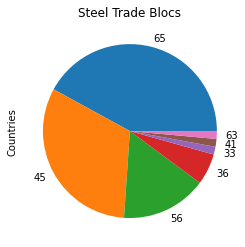

In [32]:
community_groups.plot.pie(y='Countries', labels=community_groups['Bloc'],
                         legend=False)
plt.title('Steel Trade Blocs')
plt.show()


In [33]:
major_trade_blocks('American Crude Oil')


,community,country,Countries
21,44,"[Australia, Brazil, Chile, China, France, India, Israel, Italy, Korea, Republic of, Malaysia, Norway, Peru, Spain, United States]",14
8,24,"[Austria, Bulgaria, Croatia, Cyprus, Czech Republic, Denmark, Finland, Germany, Greece, Hungary, Ireland, Netherlands, United Kingdom]",13
6,17,"[Egypt, Estonia]",2
23,47,"[Belgium, Philippines]",2
38,63,[Tunisia],1
37,62,[Thailand],1
24,48,[Poland],1
25,49,[Portugal],1
26,50,[Romania],1
27,51,[Saudi Arabia],1
